#RNN classifier for protein-coding / non-coding RNA

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
import tensorflow as tf
from tensorflow import keras
tf.keras.backend.set_floatx('float32')  # was 64, now we're running out of memory. make this 32

TINY_DATASET=False

In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls drive/'My Drive'/'Colab Notebooks'/*



Mounted at /content/drive
'drive/My Drive/Colab Notebooks/colab_RNN_tf.ipynb'
'drive/My Drive/Colab Notebooks/HellowWorld.ipynb'
'drive/My Drive/Colab Notebooks/kc_house_data.csv'
'drive/My Drive/Colab Notebooks/lncRNA_RNN_np.ipynb'
'drive/My Drive/Colab Notebooks/ncRNA.fasta'
'drive/My Drive/Colab Notebooks/pcRNA.fasta'
'drive/My Drive/Colab Notebooks/summerschool.ipynb'
'drive/My Drive/Colab Notebooks/tiny.ncRNA.fasta'
'drive/My Drive/Colab Notebooks/tiny.pcRNA.fasta'


In [12]:
MIN_SEQ_LEN=200
MAX_SEQ_LEN=25000   # out of memory, crash on CoLab
MAX_SEQ_LEN=2000    # not ideal, but see if it runs
DEFLINE='>'
ncfile="drive/My Drive/Colab Notebooks/ncRNA.fasta" # the full dataset
pcfile="drive/My Drive/Colab Notebooks/pcRNA.fasta" 
if TINY_DATASET:
  ncfile="drive/My Drive/Colab Notebooks/tiny.ncRNA.fasta" # 10 seqs for faster debugging
  pcfile="drive/My Drive/Colab Notebooks/tiny.pcRNA.fasta" 

# First try. Too slow on colab: 
# chars=tf.convert_to_tensor(list(line))
# tfarray=tf.ragged.constant(seqs)
#
# Secont try. Too slow on colab:
# chars=list(line)
# tfarray=tf.ragged.constant(seqs) ## the slow part
# 
# Fourth try. https://www.tensorflow.org/tutorials/load_data/numpy
# Various numpy tricks.
#
# Fifth try. Convert numpy arrays to python lists.
# This worked!
# 
# Assume file was preprocessed to contain one line per seq.
# Returned structure is ndarray of ndarray i.e no python lists inside.
# Numpy arrays have fixed dimenstions. Workarounds won't work for us.
# Try this. Load to numpy. Then convert to native python.
def load_fasta(filename):
    seqs=[]
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE and len(line)>=MIN_SEQ_LEN and len(line)<=MAX_SEQ_LEN:
                line=line.rstrip()
                # Python list feature converts string to list of char.
                # Numpy asarray converts list to ndarray.
                chars=np.asarray(list(line))
                seqs.append(chars.reshape(-1, 1)) 
                # Reshape is required for encoder, must change (any,) to (any,1)
    nparray=np.asarray(seqs)
    return nparray

print("Load "+ncfile)
nc_seqs = load_fasta(ncfile)
print("Load "+pcfile)
pc_seqs = load_fasta(pcfile)
nc_seqs.shape

Load drive/My Drive/Colab Notebooks/ncRNA.fasta
Load drive/My Drive/Colab Notebooks/pcRNA.fasta


(15173,)

In [13]:
encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
print("Learn DNA from first sequence in data set.")
seq=nc_seqs[0]  
encoder.fit(seq)
encoder.categories_

Learn DNA from first sequence in data set.


[array(['A', 'C', 'G', 'T'], dtype='<U1')]

In [14]:
print("Load the non-coding data")
nc_list=[]
for seq in nc_seqs:
    encoded=encoder.transform(seq)  
    nc_list.append(encoded)
    
nc_all=np.array(nc_list) # .reshape(-1,1)
print("shape: "+str(nc_all.shape))
print("element 0 is a sequence: \n"+str(nc_all[0]))
print("element 0,0 is one letter: "+str(nc_all[0][0]))

Load the non-coding data
shape: (15173,)
element 0 is a sequence: 
[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
element 0,0 is one letter: [0. 0. 0. 1.]


In [15]:
print("Load the protein-coding data")
pc_list=[]
for seq in pc_seqs:
    encoded=encoder.transform(seq)
    pc_list.append(encoded)

pc_all=np.array(pc_list) # .reshape(-1,1)
pc_all.shape[0]

Load the protein-coding data


13126

In [16]:
nc_size=nc_all.shape[0]
pc_size=pc_all.shape[0]
nc_labels=np.zeros(shape=nc_size)   # full dataset
pc_labels=np.ones(shape=pc_size)

#nc_labeled=np.concatenate((nc_all,nc_labels),axis=1)
#pc_labeled=np.concatenate((pc_all,pc_labels),axis=1)
all_seqs=np.concatenate((nc_all,pc_all),axis=0)
all_labels=np.concatenate((nc_labels,pc_labels),axis=0)

nc_seqs=None
pc_seqs=None
nc_all=Nonepc_all=None
nc_labels=None
pc_labels=None

all_seqs.shape,all_labels.shape

((28299,), (28299,))

In [17]:
splitter = ShuffleSplit(n_splits=1, test_size=0.2, random_state=37863)
for train_index,test_index in splitter.split(all_seqs):
    train_seqs =   all_seqs[train_index]
    train_labels = all_labels[train_index]
    test_seqs =    all_seqs[test_index]
    test_labels =  all_labels[test_index]
 
print("train")
print(train_seqs.shape,train_labels.shape)
print("test")
print(test_seqs.shape,test_labels.shape)

train
(22639,) (22639,)
test
(5660,) (5660,)


In [18]:
# The SimpleRNN won't accept our numpy arrays. Here is the error.
# Would it accept python lists?

def numpy_to_python_3D(np_seqs):
    one_set = []
    tlen = len(np_seqs)
    for i in range(tlen): # for every sequence in set
        one_seq = []
        slen = len(np_seqs[i])
        for j in range(slen): # for ever letter in sequence
            one_letter=np_seqs[i][j]
            one_seq.append(one_letter)
        one_set.append(one_seq)
    return one_set
train_seqs = numpy_to_python_3D(train_seqs)
test_seqs = numpy_to_python_3D(test_seqs)
train_labels = train_labels.tolist()
test_labels = test_labels.tolist()
train_seqs[0][0]

array([0., 1., 0., 0.])

In [19]:
# Now that values are shuffled, partition gives random sample.
data_size=len(train_seqs)
PARTITION=int(data_size*0.8)
print("Partition = "+str(PARTITION))

X_train=train_seqs[:PARTITION]
X_valid=train_seqs[PARTITION:]
y_train=train_labels[:PARTITION]
y_valid=train_labels[PARTITION:]
train_seqs=None
test_seqs=None
train_labels=None
test_labels=None
print("train 0,0 is one letter: \n"+str(X_train[0][0]))
print(len(X_train))
print(len(X_valid))

Partition = 18111
train 0,0 is one letter: 
[0. 1. 0. 0.]
18111
4528


In [20]:
X_train = tf.ragged.constant(X_train)  # Convert to Tensor takes a long time and hogs memory
print(type(X_train))
print(X_train.shape)
y_train = tf.convert_to_tensor(y_train)
print(type(y_train))
print(y_train.shape)
X_valid = tf.ragged.constant(X_valid)
print(type(X_valid))
print(X_valid.shape)
y_valid = tf.convert_to_tensor(y_valid)
print(type(y_valid))
print(y_valid.shape)

<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
(18111, None, None)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(18111,)
<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
(4528, None, None)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(4528,)


In [21]:
seq_len=None  # none indicates variable length
input_features=4  # one hot encoding of DNA means 4 categories
rnn2 = keras.models.Sequential([
    keras.layers.SimpleRNN(4, return_sequences=True, input_shape=[seq_len,input_features]),
    keras.layers.SimpleRNN(1),
])
bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
rnn2.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
rnn2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 4)           36        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1)                 6         
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [22]:
print("X_train "+str(X_train.shape))
print("y_train "+str(y_train.shape))
print("X_valid "+str(X_valid.shape))
print("y_valid "+str(y_valid.shape))

#history = rnn2.fit(X_train,y_train,epochs=10) # loss = 5, acc = 62.5%
#history = rnn2.fit(X_train,y_train,epochs=10,validation_split=0.5) # `validation_split` is only supported for Tensors or NumPy arrays, found: (<tf.RaggedTensor 
#history = rnn2.fit(X_train,y_train,epochs=10,validation_data=(X_valid,y_valid),batch_size=2) 
history = rnn2.fit(X_train,y_train,epochs=10,validation_data=(X_valid,y_valid)) 

# https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#fit
# UnboundLocalError: local variable 'logs' referenced before assignment
# This is a two-year old bug. The case is still open.
# It seems to happen when validation set not same size as training set.
# I tried validation set 8 and 4 for training set = 16.
# Suggestion to decrease batch_size doesn't work for me, even at size=1.
# https://github.com/tensorflow/tensorflow/issues/38064
# I get this error every time on CoLab but never on my Mac.
# Maybe it only happens on small datasets.


X_train (18111, None, None)
y_train (18111,)
X_valid (4528, None, None)
y_valid (4528,)
Epoch 1/10
566/566 [==============================] - 2616s 5s/step - loss: 1.2353 - accuracy: 0.4851 - val_loss: 0.8166 - val_accuracy: 0.4682
Epoch 2/10
566/566 [==============================] - 2595s 5s/step - loss: 0.7457 - accuracy: 0.4915 - val_loss: 0.7032 - val_accuracy: 0.5141
Epoch 3/10
566/566 [==============================] - 2592s 5s/step - loss: 0.6977 - accuracy: 0.5341 - val_loss: 0.6872 - val_accuracy: 0.5579
Epoch 4/10
566/566 [==============================] - 2573s 5s/step - loss: 0.6881 - accuracy: 0.5432 - val_loss: 0.6849 - val_accuracy: 0.5545
Epoch 5/10
566/566 [==============================] - 2555s 5s/step - loss: 0.6872 - accuracy: 0.5430 - val_loss: 0.6843 - val_accuracy: 0.5526
Epoch 6/10
566/566 [==============================] - 2556s 5s/step - loss: 0.6866 - accuracy: 0.5422 - val_loss: 0.6832 - val_accuracy: 0.5541
Epoch 7/10
566/566 [============================

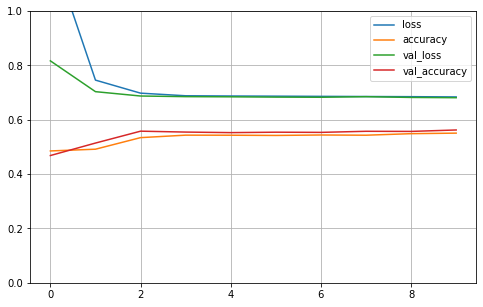

In [23]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()